<a name="Load"></a>
## Load Data 

Download the images from a GCP bucket (this only needs to run if running on colab or first run on local):

In [1]:
import pandas as pd
import requests
import io
import urllib.parse

import numpy as np

from PIL import Image



import os

import random

import datetime as dt

import matplotlib.pyplot as plt

In [2]:
SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './data/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


Read in the train, test, and sample submission CSV files as pandas dataframes:

In [3]:
BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))

In [4]:
# Read in csv files.
train_path = os.path.join(os.path.dirname(IMAGE_DIR), 'train.csv')
if os.path.exists(train_path):
    train = pd.read_csv(train_path)
else:
    train = read_csv_from_web('train.csv')
    train.to_csv(train_path, index=False)
    
test_path = os.path.join(os.path.dirname(IMAGE_DIR), 'test.csv')
if os.path.exists(test_path):
    test = pd.read_csv(test_path)
else:
    test = read_csv_from_web('test.csv')
    test.to_csv(test_path, index=False)
  

    
extra_path = os.path.join(os.path.dirname(IMAGE_DIR), 'extra_images.csv')
if os.path.exists(extra_path):
    extra = pd.read_csv(extra_path)
else:
    extra = read_csv_from_web('extra_images.csv')
    extra.to_csv(extra_path, index=False)
   
# Convert image_location strings to lowercase.
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

Quickly check the data

In [5]:
train.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [6]:
test.head()

,image_id,image_location
0,ID_6NEDKOYZ,top
1,ID_57QZ4S9N,left
2,ID_OCGGJS5X,left
3,ID_R2993S3S,top
4,ID_2E011NB0,left


In [7]:
extra.head()

,image_id,turtle_id
0,ID_Y0KYE5XD,t_id_he7JTQxO
1,ID_8JTIQ4UI,t_id_he7JTQxO
2,ID_LSXPZYSN,t_id_he7JTQxO
3,ID_SHZ2HDSP,t_id_he7JTQxO
4,ID_6TOFB06E,t_id_xry0Yg2j


## Data Exploration

What is the max/min/mean size of the images?

**Don't run, takes too long**

In [8]:

import glob
filenames = glob.glob(os.path.join(IMAGE_DIR, "*.JPG"))
sizes = [Image.open(f, 'r').size for f in filenames]
print(max(sizes))

print(min(sizes))

print(np.mean(sizes, axis=0))

(4608, 3456)
(116, 147)
[1260.48387329 1234.31317495]


How many unique turtles are in the training set?

In [9]:
print(f"There are {train.turtle_id.nunique()} unique turtles in the train set.")

There are 100 unique turtles in the train set.


How many images are there for each individual turtle in the training set?

The mean number of training images per turtle is 21.45, and the median is 16.


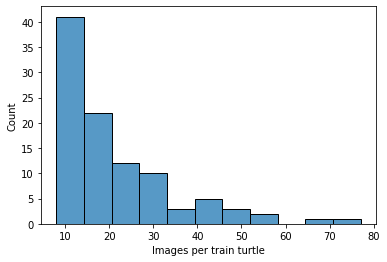

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

train_images_per_turtle = pd.value_counts(train['turtle_id'])
print('The mean number of training images per turtle is '
      f'{round(np.mean(train_images_per_turtle), 2)}, '
      f'and the median is {int(np.median(train_images_per_turtle))}.')
sns.histplot(train_images_per_turtle)
plt.xlabel('Images per train turtle')
plt.show()

We can plot the number of images per `turtle_id`:


In [9]:
images_per_turtle = pd.value_counts(train['turtle_id'])
plt.figure(figsize=(3, 21))
sns.barplot(x=images_per_turtle, y=images_per_turtle.index,
            palette='Blues_r', orient='horizontal')
plt.show()

NameError: name 'plt' is not defined

Let's visualize a random turtle

In [10]:
import matplotlib.image as mpimg

import random

/tmp/ipykernel_12317/1161797128.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


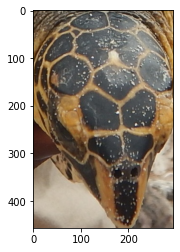

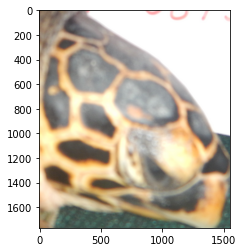

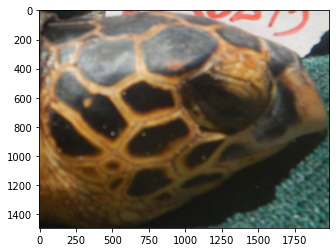

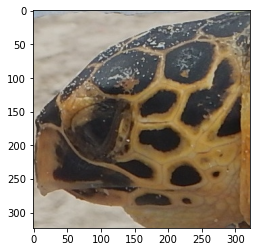

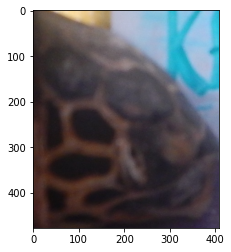

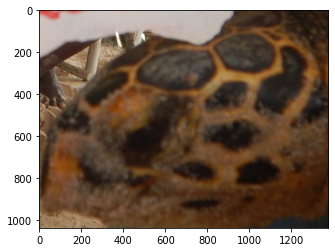

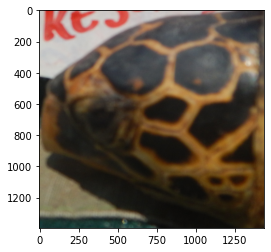

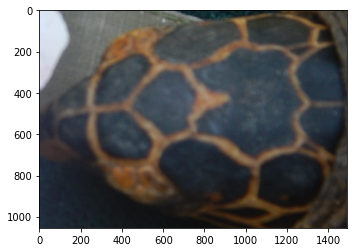

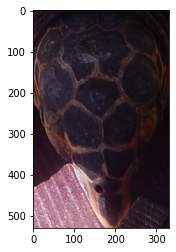

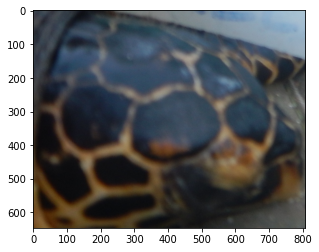

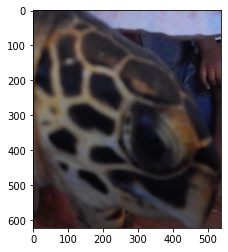

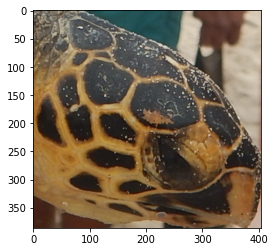

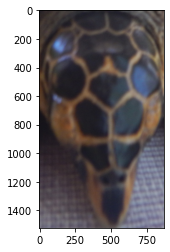

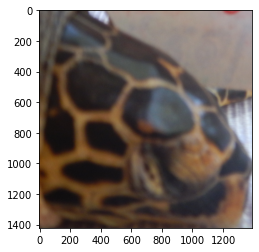

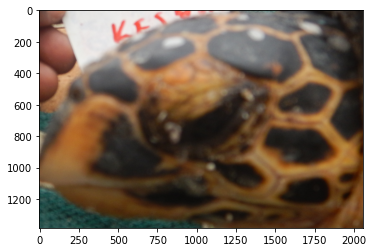

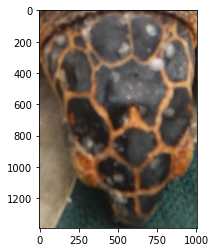

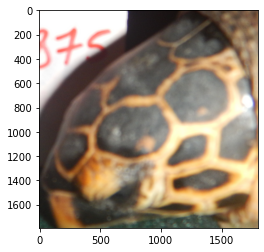

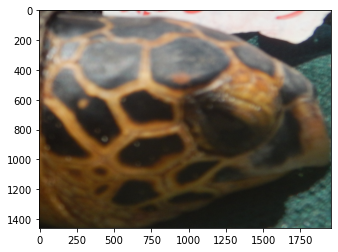

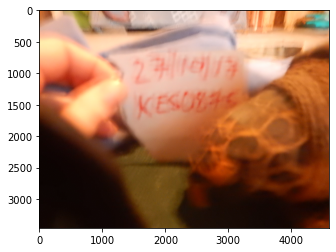

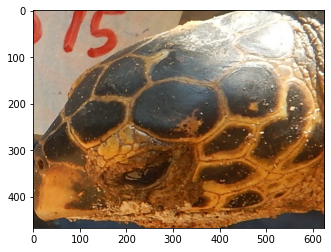

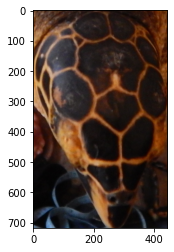

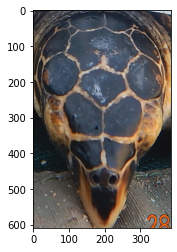

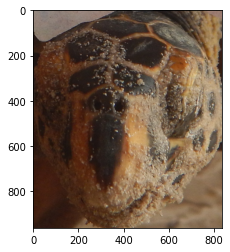

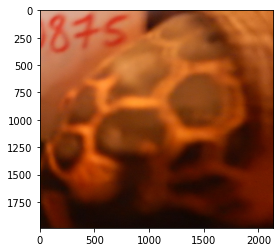

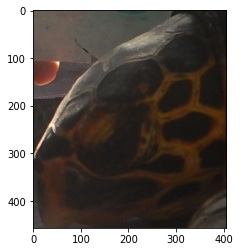

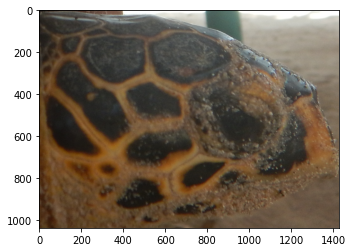

In [11]:
sample_turtle_set = train[train.turtle_id.sample().values[0]==train.turtle_id].reset_index()
for ix, row in sample_turtle_set.iterrows():
  plt.figure()
  plt.imshow(mpimg.imread(os.path.join(IMAGE_DIR, row['image_id']+'.JPG')))

## Datasets and Dataloaders

In [8]:
import numpy as np
import torch
# from skimage import io
from torch.utils.data import Dataset
from torchvision import transforms

### Dataset for Triplet Loss

In [9]:
# Dataset to generate triplets (anchor, positive, negative) for training
class TripletDataset(Dataset):

    def __init__(self, root_dir, labels_df, num_triplets, easy_mode=False, transform=None):

        self.root_dir = root_dir
        self.df = labels_df
        self.num_triplets = num_triplets
        self.transform = transform
        self.training_triplets = self.generate_triplets(self.df, self.num_triplets, easy_mode)
        self.easy_mode = easy_mode


    @staticmethod
    def generate_triplets(df, num_triplets, easy_mode):

        def make_dictionary_for_face_class(df, easy_mode):
            orientations = df['image_location'].unique().tolist()
            turtle_classes = {}
            if easy_mode:
              for turtle_id in train['turtle_id'].unique():
                for orientation in orientations:
                  turtle_image_ids = train[(train['turtle_id']==turtle_id) & (train['image_location']==orientation)]['image_id'].tolist()
                  turtle_classes[turtle_id]=turtle_image_ids
            else:
              for turtle_id in train['turtle_id'].unique():
                turtle_image_ids = train[train['turtle_id']==turtle_id]['image_id'].tolist()
                turtle_classes[turtle_id]=turtle_image_ids
            return turtle_classes

        triplets = []
        classes = df['turtle_id'].unique()
        turtle_classes = make_dictionary_for_face_class(df, easy_mode)

        for _ in range(num_triplets):

            '''
              - randomly choose anchor, positive and negative images for triplet loss
              - anchor and positive images in pos_class
              - negative image in neg_class
              - at least, two images needed for anchor and positive images in pos_class
              - negative image should have different class as anchor and positive images by definition
            '''

            pos_class = np.random.choice(classes)
            neg_class = np.random.choice(classes)
            while len(turtle_classes[pos_class]) < 2:
                pos_class = np.random.choice(classes)
            while pos_class == neg_class:
                neg_class = np.random.choice(classes)


            if len(turtle_classes[pos_class]) == 2:
                ianc, ipos = np.random.choice(2, size=2, replace=False)
            else:
                ianc = np.random.randint(0, len(turtle_classes[pos_class]))
                ipos = np.random.randint(0, len(turtle_classes[pos_class]))
                while ianc == ipos:
                    ipos = np.random.randint(0, len(turtle_classes[pos_class]))
            ineg = np.random.randint(0, len(turtle_classes[neg_class]))

            anc_id = turtle_classes[pos_class][ianc]
            pos_id = turtle_classes[pos_class][ipos]
            neg_id = turtle_classes[neg_class][ineg]

            triplets.append(
                [anc_id, pos_id, neg_id, pos_class, neg_class])

        return triplets

    def __getitem__(self, idx):
        anc_id, pos_id, neg_id, pos_class, neg_class = self.training_triplets[idx]

        anc_img = os.path.join(self.root_dir, anc_id +'.JPG')
        pos_img = os.path.join(self.root_dir, pos_id +'.JPG')
        neg_img = os.path.join(self.root_dir, neg_id +'.JPG')

        anc_img = Image.open(anc_img)
        pos_img = Image.open(pos_img)
        neg_img = Image.open(neg_img)

        # pos_class = torch.from_numpy(np.array([pos_class]).astype('long'))
        # neg_class = torch.from_numpy(np.array([neg_class]).astype('long'))

        sample = {'anc_img': anc_img, 'pos_img': pos_img, 'neg_img': neg_img, 'pos_class': pos_class,
                  'neg_class': neg_class}

        if self.transform:
            sample['anc_img'] = self.transform(sample['anc_img'])
            sample['pos_img'] = self.transform(sample['pos_img'])
            sample['neg_img'] = self.transform(sample['neg_img'])

        return sample

    def __len__(self):
        return len(self.training_triplets)

### Simple Dataset 
Treats the problem as a simple classification problem

In [96]:
# Dataset to generate triplets (anchor, positive, negative) for training
class TurtleDataSet(Dataset):
    """
    Args:
        root_dir (string): Root directory of dataset  images
        labels_df (Dataframe): 
        label_ids (list): list of ids in training set
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        include_orientation (boolean, optional): whether to include orientation as well
    """
    def __init__(self, root_dir, labels_df, label_ids, transform=None, include_orientation=True):

        self.root_dir = root_dir
        self.include_orientation = include_orientation
        if self.include_orientation:
            # self.df = pd.concat([labels_df['image_id'], 
            #                      pd.get_dummies(labels_df['image_location']), 
            #                      pd.get_dummies(labels_df['turtle_id'])], 
            #                     axis=1)
            self.df = labels_df
        else:
            self.df = labels_df[['image_id', 'turtle_id']]
        # self.df = pd.concat([labels_df['image_id'], pd.get_dummies(labels_df['image_location']), labels_df['turtle_id']], axis=1)
        self.turtle_ids = label_ids
        self.transform = transform
        self.orientation_map = {'left': 0,
                                'right': 1,
                                'top': 2}

    def __getitem__(self, idx):

        # id_labels = self.df.loc[idx, self.df.columns.str.startswith('t_id')].values.argmax()
        # id_labels = self.df.loc[idx, self.df.columns.str.startswith('t_id')].values
        
        
        turtle_id = self.df.loc[idx, 'turtle_id']
        try:
            id_label = turtle_ids.index(turtle_id)
        except ValueError:
            id_label = len(self.turtle_ids)
        
        image_id = self.df.loc[idx, 'image_id']
        img_path = os.path.join(self.root_dir, image_id +'.JPG')
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
            
        
        if self.include_orientation:
            orientation_label = self.orientation_map[self.df.loc[idx, 'image_location']]

            return {'img':img,
                    'image_id':image_id,
                    'id':id_label, 
                    'orientation':orientation_label}
        else:
            
            return {'img':img, 
                    'image_id':image_id,
                    'id':id_label}

    def __len__(self):
        return len(self.df)

Add some unknown turtles to the training set

In [356]:
turtle_ids = train.turtle_id.unique().tolist()

In [357]:
unknown_ids = set(extra.turtle_id.unique()) - set(train.turtle_id.unique())

unknown_train_ids = random.sample(list(unknown_ids), 100)

train_df = [train]
for unknown_train_id in unknown_train_ids:
    train_df.append(extra[extra.turtle_id==unknown_train_id])

train_df = pd.concat(train_df).reset_index()

In [358]:
len(train)

2145

In [359]:
len(unknown_ids)

2165

In [360]:
print("%d images of unkown turtles added"%train_df.image_location.isna().sum())

419 images of unkown turtles added


In [361]:
train_df.loc[train_df.image_location.isna(), 'turtle_id'] = 'new_turtle'

In [362]:
train_df = train_df.drop('index', axis=1)

In [364]:
turtle_weights = (train_df.groupby('turtle_id')['image_id'].count()/train_df.shape[0]).reset_index().sort_values('turtle_id', ascending=False).reset_index(drop=True)

In [365]:
turtle_ids = turtle_weights['turtle_id'].tolist()[:-1]

In [202]:
import torchvision
from torchvision import models, transforms

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Image Transforms

In [16]:
# A custom transform to pad all images in a batch to same size,  taken from https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/5
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

## Competition Metrics

In [27]:
def apk(actual, predicted, k=5):
  """Computes the average precision at k.

  Args:
    actual: The turtle ID to be predicted.
    predicted : A list of predicted turtle IDs (order does matter).
    k : The maximum number of predicted elements.

  Returns:
    The average precision at k.
  """
  if len(predicted) > k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
    if p == actual and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits / (i + 1.0)

  return score


def mapk(actual, predicted, k=5):
  """ Computes the mean average precision at k.

    The turtle ID at actual[i] will be used to score predicted[i][:k] so order
    matters throughout!

    actual: A list of the true turtle IDs to score against.
    predicted: A list of lists of predicted turtle IDs.
    k: The size of the window to score within.

    Returns:
      The mean average precision at k.
  """
  return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [257]:
def get_id_from_idx(idx):
    try:
        return turtle_ids[idx]
    except IndexError:
        return "new_turtle"

mapper = np.vectorize(get_id_from_idx)

## As Classification

### Alexnet

In [366]:
model_conv = torchvision.models.alexnet(pretrained=True)

In [367]:
# Freeze all weights
for param in model_conv.parameters():

    param.requires_grad = False

    

# Add a new layer on top
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Sequential(nn.Linear(num_ftrs,len(turtle_ids)+1), nn.ReLU())
# model_conv.classifier[6] = nn.Linear(num_ftrs,100)

# Unfreeze the weights of the classifier
for name, child in model_conv.named_children():
    if name=='classifier':
        child.requires_grad_(True)

In [368]:
img_transform = transforms.Compose([
                                    SquarePad(),
                                    transforms.PILToTensor(),
                                    transforms.ConvertImageDtype(torch.float32),
                                    transforms.Resize((128,128))
                                                      ])

In [369]:
optimizer_model = optim.SGD(
            params=filter(lambda p: p.requires_grad, model_conv.parameters()),
            lr=0.0001,
            momentum=0.0,
            dampening=0,
            nesterov=False
        )

# optimizer_model = optim.Adam(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.001,
#             betas=(0.9, 0.999),
#             eps=1e-08,
#             amsgrad=False,
#             weight_decay=1e-5
#         )

In [370]:
dataset = TurtleDataSet(IMAGE_DIR, train_df, turtle_ids, transform=img_transform, include_orientation=False)

In [371]:
# cross_entropy = nn.CrossEntropyLoss(weight=torch.tensor(turtle_weights['image_id'].values, dtype=torch.float).to(device))
cross_entropy = nn.CrossEntropyLoss()

In [23]:
import tqdm

from torch.cuda.amp import GradScaler, autocast

In [372]:
model_conv.to(device)
model_conv.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [373]:
scaler = GradScaler()

In [374]:
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer_model, 
                                                 base_lr=0.00001, 
                                                 max_lr=0.005, 
                                                 step_size_up=21, 
                                                 step_size_down=42)

In [375]:
top_k_precisions = []
epoch_losses = []

In [376]:
for epoch in range(25):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    
    running_loss = 0.0
    
    for sample in pbar:
        optimizer_model.zero_grad() 
        with autocast():
            op = model_conv(sample['img'].to(device))
            loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        lr_scheduler.step()
        running_loss += loss.item() * sample['img'].size(0)
        top_k_precision = mapk(sample['id'], op.topk(5, dim=1).indices)
        top_k_precisions.append(top_k_precision)
        pbar.set_description('Epoch %d - MAP@k : %f - Learning Rate : %f' % (epoch+1, top_k_precision, lr_scheduler.get_last_lr()[0]))
    epoch_loss = running_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    print('Epoch %d - MAP@k : %f - Loss %f' % (epoch+1, np.mean(top_k_precisions[-21:]), epoch_loss))

  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]/home/xion/.conda/envs/torchenv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 1 - MAP@k : 0.000000 - Learning Rate : 0.005000: 100%|██████████████████████████████████████████████████████████████| 21/21 [03:04<00:00,  8.78s/it]
  0%|                                                                                                                      

Epoch 1 - MAP@k : 0.121422 - Loss 4.449170


Epoch 2 - MAP@k : 0.250000 - Learning Rate : 0.002505: 100%|██████████████████████████████████████████████████████████████| 21/21 [02:43<00:00,  7.78s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 2 - MAP@k : 0.196956 - Loss 4.172045


Epoch 3 - MAP@k : 0.050000 - Learning Rate : 0.000010: 100%|██████████████████████████████████████████████████████████████| 21/21 [01:58<00:00,  5.62s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 3 - MAP@k : 0.238585 - Loss 3.936237


Epoch 4 - MAP@k : 0.625000 - Learning Rate : 0.005000: 100%|██████████████████████████████████████████████████████████████| 21/21 [01:40<00:00,  4.78s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 4 - MAP@k : 0.271137 - Loss 3.873703


Epoch 5 - MAP@k : 0.583333 - Learning Rate : 0.002505: 100%|██████████████████████████████████████████████████████████████| 21/21 [01:32<00:00,  4.42s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 5 - MAP@k : 0.286024 - Loss 3.833922


Epoch 6 - MAP@k : 0.300000 - Learning Rate : 0.000010: 100%|██████████████████████████████████████████████████████████████| 21/21 [01:49<00:00,  5.19s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 6 - MAP@k : 0.289701 - Loss 3.703946


Epoch 7 - MAP@k : 0.625000 - Learning Rate : 0.005000: 100%|██████████████████████████████████████████████████████████████| 21/21 [01:45<00:00,  5.01s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 7 - MAP@k : 0.332112 - Loss 3.590010


Epoch 8 - MAP@k : 0.208333 - Learning Rate : 0.002505: 100%|██████████████████████████████████████████████████████████████| 21/21 [01:53<00:00,  5.39s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 8 - MAP@k : 0.316140 - Loss 3.580127


Epoch 9 - MAP@k : 0.750000 - Learning Rate : 0.000010: 100%|██████████████████████████████████████████████████████████████| 21/21 [02:25<00:00,  6.91s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 9 - MAP@k : 0.357732 - Loss 3.454765


Epoch 10 - MAP@k : 0.500000 - Learning Rate : 0.005000: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:39<00:00,  4.75s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 10 - MAP@k : 0.375329 - Loss 3.360012


Epoch 11 - MAP@k : 0.250000 - Learning Rate : 0.002505: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:31<00:00,  4.37s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 11 - MAP@k : 0.360938 - Loss 3.351402


Epoch 12 - MAP@k : 0.562500 - Learning Rate : 0.000010: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:34<00:00,  4.48s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 12 - MAP@k : 0.400322 - Loss 3.219168


Epoch 13 - MAP@k : 0.562500 - Learning Rate : 0.005000: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:07<00:00,  6.08s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 13 - MAP@k : 0.431002 - Loss 3.105128


Epoch 14 - MAP@k : 0.750000 - Learning Rate : 0.002505: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:05<00:00,  5.98s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 14 - MAP@k : 0.444606 - Loss 3.068486


Epoch 15 - MAP@k : 0.375000 - Learning Rate : 0.000010: 100%|█████████████████████████████████████████████████████████████| 21/21 [01:54<00:00,  5.46s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 15 - MAP@k : 0.461341 - Loss 2.930867


Epoch 16 - MAP@k : 0.500000 - Learning Rate : 0.005000: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:13<00:00,  6.37s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 16 - MAP@k : 0.478472 - Loss 2.847192


Epoch 17 - MAP@k : 0.750000 - Learning Rate : 0.002505: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:03<00:00,  5.86s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 17 - MAP@k : 0.486186 - Loss 2.824555


Epoch 18 - MAP@k : 0.500000 - Learning Rate : 0.000010: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:22<00:00,  6.79s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 18 - MAP@k : 0.517188 - Loss 2.653397


Epoch 19 - MAP@k : 0.562500 - Learning Rate : 0.005000: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:18<00:00,  6.58s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 19 - MAP@k : 0.543967 - Loss 2.575661


Epoch 20 - MAP@k : 0.625000 - Learning Rate : 0.002505: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:32<00:00,  7.25s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 20 - MAP@k : 0.506324 - Loss 2.715883


Epoch 21 - MAP@k : 0.750000 - Learning Rate : 0.000010: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:15<00:00,  6.45s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 21 - MAP@k : 0.567026 - Loss 2.469465


Epoch 22 - MAP@k : 0.250000 - Learning Rate : 0.005000: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:26<00:00,  6.98s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 22 - MAP@k : 0.554526 - Loss 2.394225


Epoch 23 - MAP@k : 0.500000 - Learning Rate : 0.002505: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:24<00:00,  6.90s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 23 - MAP@k : 0.567665 - Loss 2.388959


Epoch 24 - MAP@k : 0.625000 - Learning Rate : 0.000010: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:20<00:00,  6.70s/it]
  0%|                                                                                                                              | 0/21 [00:00<?, ?it/s]

Epoch 24 - MAP@k : 0.583743 - Loss 2.322622


Epoch 25 - MAP@k : 0.562500 - Learning Rate : 0.005000: 100%|█████████████████████████████████████████████████████████████| 21/21 [02:08<00:00,  6.12s/it]

Epoch 25 - MAP@k : 0.618626 - Loss 2.182767


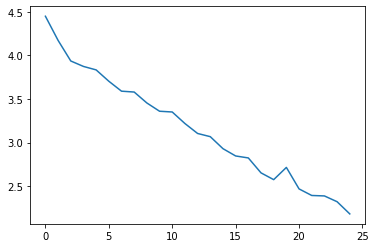

In [377]:
plt.plot(epoch_losses)

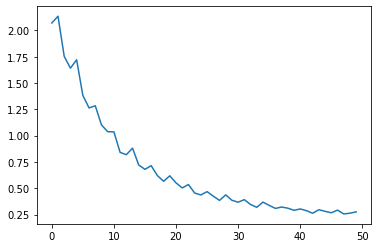

In [276]:
plt.plot(epoch_losses)

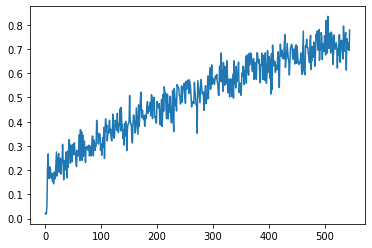

In [303]:
plt.plot(top_k_precisions)

### Validation on extra images

In [304]:
extra_dataset = TurtleDataSet(IMAGE_DIR, extra,turtle_ids, transform=img_transform, include_orientation=False)

In [378]:
model_conv.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [379]:
data_loader = torch.utils.data.DataLoader(extra_dataset, batch_size=8, shuffle=False, num_workers=1)
pbar = tqdm.tqdm(data_loader)
model_conv.eval()
preds = []
image_ids = []
with torch.no_grad():
    for sample in pbar:
        out = model_conv(sample['img'].to(device))
        break
        top_k_precision = mapk(sample['id'], out.topk(5, dim=1).indices)
        top_k_precisions.append(top_k_precision)
        pred = out.topk(5, dim=1).indices.cpu().numpy()
        preds.append(pred)


  0%|                                                                                                                            | 0/1333 [00:01<?, ?it/s]


In [380]:
out.topk(5, dim=1)

torch.return_types.topk(
values=tensor([[7.6685, 4.5374, 3.6420, 3.1893, 2.8860],
        [6.2215, 4.9557, 3.9997, 3.9463, 3.2040],
        [6.9583, 3.8012, 3.4793, 3.2162, 2.7154],
        [5.1671, 3.1837, 3.1532, 3.0782, 2.8512],
        [6.8738, 6.2914, 4.9994, 4.8615, 4.5233],
        [6.4562, 6.2972, 6.1919, 5.2483, 5.1193],
        [7.9844, 5.5844, 4.6487, 4.5515, 4.5479],
        [7.3806, 6.6360, 6.3454, 6.3134, 5.1230]], device='cuda:0'),
indices=tensor([[100,   1,  89,  52,  98],
        [100,  21,  41,  57,   7],
        [100,  54,  89,  78,   7],
        [100,  89,  71,  52,   1],
        [100,  85,   7,  21,  71],
        [ 85,  89,  52, 100,  71],
        [100,  89,  21,  52,   7],
        [100,  22,  89,  52,  71]], device='cuda:0'))

In [334]:
preds = np.concatenate(preds)

In [335]:
preds.shape

(10658, 5)

In [336]:
sum(preds==100)

array([7266,  695,  380,  215,  200])

In [ ]:
preds = mapper(preds)

predictions_df = pd.DataFrame({'image_id': image_ids,
                               'prediction1': preds[:, 0],
                               'prediction2': preds[:, 1],
                               'prediction3': preds[:, 2],
                               'prediction4': preds[:, 3],
                               'prediction5': preds[:, 4]})

In [307]:
np.mean(top_k_precisions)

0.6532054888722181

In [308]:
reserved_mem = torch.cuda.memory_reserved(0)
allocated_mem = torch.cuda.memory_allocated(0)

mem_use = allocated_mem/reserved_mem

In [309]:
mem_use

0.8571101664038608

### Custom Model
Trained from scratch

In [75]:
class TurtleNet(nn.Module):
    def __init__(self):
        super(TurtleNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Flatten()
        )
        
        self.feature_classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=32768, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=512, out_features=100, bias=True)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.feature_classifier(x)
        return x 

In [76]:
model_conv = TurtleNet()

In [77]:
img_transform = transforms.Compose([
                                    transforms.Grayscale(num_output_channels=1),
                                    SquarePad(),
                                    transforms.PILToTensor(),
                                    transforms.ConvertImageDtype(torch.float32),
                                    transforms.Resize((128,128))
                                                      ])

In [381]:
# Clear out anymemory if possible
torch.cuda.empty_cache()

In [382]:
model_conv.to(device)
model_conv.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [81]:
scaler = GradScaler()

In [84]:
dataset = TurtleDataSet(IMAGE_DIR, train, transform=img_transform)

In [82]:
optimizer_model = optim.SGD(
            params=filter(lambda p: p.requires_grad, model_conv.parameters()),
            lr=0.0001,
            momentum=0.0,
            dampening=0,
            nesterov=False
        )

# optimizer_model = optim.Adam(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.001,
#             betas=(0.9, 0.999),
#             eps=1e-08,
#             amsgrad=False,
#             weight_decay=1e-5
#         )

In [85]:

# with torch.set_grad_enabled(True):
for epoch in range(10):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=1)
    pbar = tqdm.tqdm(data_loader)
    for sample in pbar:
        # break
        optimizer_model.zero_grad() 
        with autocast():
            op = model_conv(sample['img'].to(device))
            loss = cross_entropy(op, sample['id'].to(device))
        scaler.scale(loss).backward()
        scaler.step(optimizer_model)
        scaler.update()
        pbar.set_description('Epoch %d - Loss : %f' % (epoch+1, loss.item()))


Epoch 10 - Loss : 4.625000: 100%|███████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:48<00:00,  5.51it/s]


## As Margin Maximization

In [389]:
triplet_loss = nn.TripletMarginWithDistanceLoss(distance_function=nn.CosineSimilarity(), margin=0.01)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cuda', index=0)

In [383]:
dataset = TripletDataset(IMAGE_DIR, train, 32768, transform=img_transform, easy_mode=True)

In [390]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

In [385]:
optimizer_model = optim.SGD(
            params=filter(lambda p: p.requires_grad, model_conv.parameters()),
            lr=0.0001,
            momentum=0.0,
            dampening=0,
            nesterov=False
        )

# optimizer_model = optim.Adam(
#             params=filter(lambda p: p.requires_grad, model_conv.parameters()),
#             lr=0.001,
#             betas=(0.9, 0.999),
#             eps=1e-08,
#             amsgrad=False,
#             weight_decay=1e-5
#         )

In [39]:
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2060', major=7, minor=5, total_memory=6144MB, multi_processor_count=30)

In [20]:
import tqdm

from torch.cuda.amp import GradScaler, autocast

In [21]:
scaler = GradScaler()

In [22]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

In [386]:
model_conv.to(device)
model_conv.train()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [391]:
pbar = tqdm.tqdm(data_loader)
# with torch.set_grad_enabled(True):
for triplet in pbar:
    optimizer_model.zero_grad() 
    with autocast():
        anc_embed = model_conv(triplet['anc_img'].to(device))
        pos_embed = model_conv(triplet['pos_img'].to(device))
        neg_embed = model_conv(triplet['neg_img'].to(device))
        loss = triplet_loss(anc_embed, pos_embed, pos_embed)
    scaler.scale(loss).backward()
    scaler.step(optimizer_model)
    scaler.update()
    pbar.set_description('Loss : %f' % loss.item())


Loss : 0.010000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [36:59<00:00,  1.85it/s]


In [ ]:
reserved_mem = torch.cuda.memory_reserved(0)
allocated_mem = torch.cuda.memory_allocated(0)

In [ ]:
from google.colab import files

predictions_from_scratch.to_csv('submission.csv')
files.download('submission.csv')

## Generate Result for test set

In [47]:
test['turtle_id'] = ''

In [347]:
model_conv.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [348]:
test_dataset = TurtleDataSet(IMAGE_DIR, test, turtle_ids, transform=img_transform, include_orientation=False)

In [349]:
data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)

preds = []
image_ids = []
pbar = tqdm.tqdm(data_loader)
model_conv.eval()
with torch.no_grad():
    for sample in pbar:
        image_ids.extend(sample['image_id'])
        out = model_conv(sample['img'].to(device))
        pred = out.topk(5, dim=1).indices.cpu().numpy()
        preds.append(pred)
        # break


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:17<00:00,  3.62it/s]


In [350]:
image_ids = list(map(lambda x:x.upper(), image_ids))

In [351]:
preds = np.concatenate(preds)

In [352]:
sum(preds==100)

array([100,  47,  32,  19,  23])

In [353]:
preds = mapper(preds)

predictions_df = pd.DataFrame({'image_id': image_ids,
                               'prediction1': preds[:, 0],
                               'prediction2': preds[:, 1],
                               'prediction3': preds[:, 2],
                               'prediction4': preds[:, 3],
                               'prediction5': preds[:, 4]})

In [354]:
predictions_df.to_csv(os.path.join('predictions', dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S.csv")),
                      index=False)

In [328]:
len(image_ids)

490

array([[ 29,  32,  21,   1,  43],
       [ 54,  22,   3,  83,  14],
       [ 15,   3,  63,  54,  65],
       [ 71,  52,  84,  42,  27],
       [ 13,  31,   3,  38,  25],
       [ 59,  49,  33,  43,  90],
       [  2,  30,  43,  76,   7],
       [ 31, 100,  46,  16,  93]])

In [95]:
mapper(out.topk(5, dim=1).indices.cpu().numpy())

array([['t_id_15bo4NKD', 't_id_Kc1tXDbJ', 't_id_DPYQnZyv',
        't_id_qZ0iZYsC', 't_id_8b8sprYe'],
       ['t_id_uJXT7dGu', 't_id_ROFhVsy2', 't_id_YjXYTCGC',
        't_id_GOIvCduN', 't_id_NW7wn8TC'],
       ['t_id_JI6ba2Yx', 't_id_YjXYTCGC', 't_id_D0gA44av',
        't_id_uJXT7dGu', 't_id_MwnEYfqe'],
       ['t_id_fxTQ5vHC', 't_id_72SiiZCp', 't_id_pCO59rOk',
        't_id_bYageLYA', 't_id_mpuNp8mf'],
       ['t_id_Ts5LyVQz', 't_id_Kf73l69A', 't_id_YjXYTCGC',
        't_id_tjWepji1', 't_id_AOWArhGb'],
       ['t_id_WDCMGvI4', 't_id_B7LaSiac', 't_id_2Yn71r7R',
        't_id_8b8sprYe', 't_id_2E8o5Jtl'],
       ['t_id_3b65X5Lw', 't_id_QqeoI5F3', 't_id_8b8sprYe',
        't_id_VFb44eFm', 't_id_utw0thCe'],
       ['t_id_Kf73l69A', 'new_turtle', 't_id_smNwfXAT', 't_id_ifWwxWF4',
        't_id_Lhp87PBX']], dtype='<U13')

In [84]:
sample_submission = read_csv_from_web('sample_submission.csv')

In [89]:
sample_submission.head()

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_6NEDKOYZ,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
1,ID_57QZ4S9N,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
2,ID_OCGGJS5X,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
3,ID_R2993S3S,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
4,ID_2E011NB0,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor


In [110]:
sample['img'].shape

torch.Size([8, 3, 128, 128])

In [111]:
sample['id']

tensor([26,  8, 76, 60, 66, 66, 55, 34])

In [125]:
mapk(sample['id'], out.topk(5, dim=1).indices)

0.14583333333333331

In [ ]:
mapk(out,)

In [ ]:
predictions = predictions_from_scratch[[
    "prediction1", "prediction2", "prediction3", "prediction4", "prediction5"
]]
y_predict = predictions.values.tolist()

# We don't actually know the true labels for the test set, so for the purposes
# of demonstration we just assume that all of the images in the test set are of
# a single turtle:
assumed_y = ["t_id_d6aYXtor"] * len(y_predict)

mapk_result = mapk(assumed_y, y_predict, k=5)
print("With made up test set labels, our mapk with k=5 is", mapk_result)